Using OpenCV, I processed the extremist and non-extremist videos and saved one frame for every second, labeling each frame appropriately 

I'm limited by the amount of non-extremist frames I have, so I only save up to 2749 extremist frames

In [ ]:
import cv2 
import os

count = 0
videocount = 0
totalFrames = 0
newTestingDir = '/home/brady/classifier/venv/classifier/2ndAttemptFrames'

# loop through videos in video directory
for x in os.listdir(directory):
    
    if x.endswith(".mp4"): 
        cap1 = cv2.VideoCapture(x)
        fps = int(cap1.get(cv2.CAP_PROP_FPS))
        
        if not cap1.isOpened():
            print("Error opening video")
            
        framecount = 0
        count = 0
        
        videoname = x.split(".")

        # save every second of video
        while cap1.isOpened():
            returned1, frame1 = cap1.read()
            framecount+=1
            
            if returned1 and framecount == fps * 1:
                if totalFrames < 2749:
                    framecount = 0
                    count +=1
                    cv2.imwrite(os.path.join(newTestingDir,videoname[0] + "_frame_" + str(count) + ".jpg"),frame1)
                    totalFrames+=1
        
            # break when end of video
            elif not returned1:
                videocount += 1
                cap1.release()
                cv2.destroyAllWindows()
                break



I add the frames to train_x and add a 1 to train_y if the corresponding frame is extremist and 0 if not, and I resize the frames to a size that is compatible with the pre-trained VGG model. I also use Sklearn train_test_split function to split the dataset

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
from keras.utils import normalize
from sklearn.model_selection import train_test_split

train_dir = '/home/brady/classifier/venv/classifier/2ndAttemptFrames'
train_x = []
train_y = []
size = 224

for img in os.listdir(train_dir):
    
    if img.endswith(".jpg"):       
        word_label = img.split('.')[0]
        image = cv2.imread(os.path.join(train_dir,img))
        image = Image.fromarray(image)
        image = image.resize((size,size))
        
        if word_label.find("extremism") != -1: 
            train_x.append(np.array(image))
            train_y.append(1)

        else:
            train_x.append(np.array(image))
            train_y.append(0)
        
train_x = np.array(train_x)
train_y = np.array(train_y)
X_train, X_test, y_train, y_test = train_test_split(train_x,train_y,test_size = 0.20, random_state=0)


Before using the pre-trained VGG model, I wanted to try to make a standard CNN with 2 convolutional layers and 2 max pooling layers

In [51]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import normalize
from keras.layers import BatchNormalization

X_train = normalize(X_train,axis=1)
X_test = normalize(X_test,axis=1)
shape = (size, size, 3)

# 2 conv layers, 2 maxpooling layers
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(64))

model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))  

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',            
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',patience=5)

model.summary() 
history = model.fit(X_train, 
                    y_train, 
                    batch_size = 32,  
                    epochs = 100,      
                    validation_data=(X_test,y_test),callbacks = [early_stopping])

model.save('weights.h5')  

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 223, 223, 32)      896       
_________________________________________________________________
batch_normalization_53 (Batc (None, 223, 223, 32)      128       
_________________________________________________________________
activation_108 (Activation)  (None, 223, 223, 32)      0         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
batch_normalization_54 (Batc (None, 109, 109, 32)      128       
_________________________________________________________________
activation_109 (Activation)  (None, 109, 109, 32)    

Overall, the results look a little wacky since there are sudden spikes in the validation loss near the end of the training, so I move on to using the VGG model as my base 

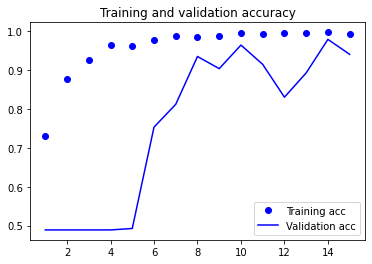

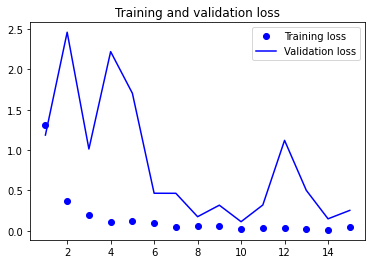

In [52]:
# standard CNN, adjusted
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

I use the pre-trained VGG16 model as the base of the model and add supplementary layers on top. I addded the dropout in an attempt to minimize overfitting

I experimented with the model by changing the dropout rate, the batch size, removing some layers, and using different optimizers. I plotted the ones that had good results, although the training loss does have an unexplained spike in the beginning

In [5]:
import tensorflow
from keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.05)(x)
pred = Dense(1,activation='sigmoid')(x)

model = Model(inputs = base_model.input,outputs=pred)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
train_data = tensorflow.data.Dataset.from_tensor_slices((X_train,y_train))
train_data = train_data.cache().shuffle(10000).batch(128)
early_stopping = EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(train_data, 
                    epochs = 100,      
                    validation_data=(X_test,y_test),
                    callbacks = [early_stopping])

model.save('weights_vgg16.h5')


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

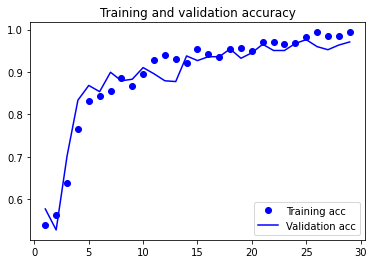

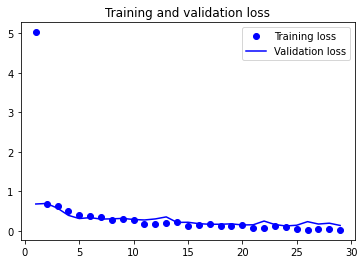

In [5]:
#VGG16, 64 batch size, adam optimizer

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

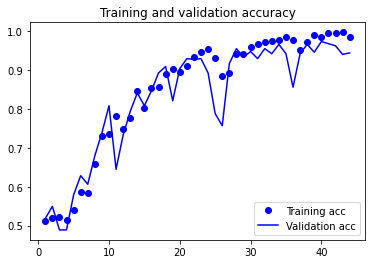

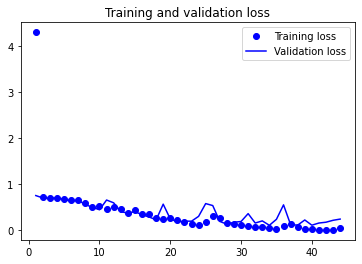

In [10]:
#VGG16, 128 batch size, adam optimizer
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

I manually test out the model that was trained using a batch size of 64 and the adam optimizer, and I also use the evaluate function to see how the model fares against the validation set as a whole

The prediction for this image is:  [[1.8395903e-07]]
The actual label for this image is:  0
18/18 [==============================] - 0s 27ms/step - loss: 0.1325 - accuracy: 0.9707
Accuracy =  97.0695972442627 %


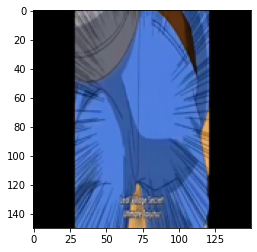

In [45]:
from keras.models import load_model
model = load_model('weights_vgg16.h5')

# extremism = 1, nonextremism = 0

n = 200
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

acc,acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

The prediction for this image is:  [[5.5308973e-30]]
The actual label for this image is:  0


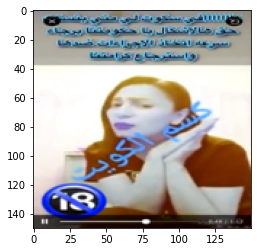

In [43]:
from keras.models import load_model
model = load_model('weights_vgg16.h5')
# extremism = 1, nonextremism = 0

n=100
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])

The prediction for this image is:  [[0.99991584]]
The actual label for this image is:  1


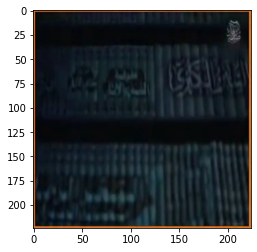

In [9]:
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()
model = load_model('weights_vgg16.h5')

# extremism = 1, nonextremism = 0

n=500
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_test[n])
tf.keras.backend.clear_session()

I process unlabeled data and see how well or poorly the model detects extremist videos

In [20]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model
import os
from PIL import Image
directory = '/home/brady/classifier/venv/classifier/newData/newVideos'
newDir = '/home/brady/classifier/venv/classifier/newData/newVideos/newVideoFrames'
for x in os.listdir(directory):
    
    if x.endswith(".mp4"):
        cap1 = cv2.VideoCapture(x)
        if not cap1.isOpened():
            print("Error opening video")
        print("Processing",x)
        videoname = x.split(".")
        framecount = 0
        countFrames = 0
        
        while cap1.isOpened():
 
                returned, frame = cap1.read()
                fps = int(cap1.get(cv2.CAP_PROP_FPS))
                framecount += 1
              
                if returned and (framecount == fps * 1):
                    cv2.imwrite(os.path.join(newDir,videoname[0] + "_frame_" + str(countFrames) + ".jpg"),frame)
                    countFrames = countFrames + 1
                    framecount = 0
                elif not returned:
                    cap1.release()
                    break

Processing 5Bv5TH1hRVivGGPq.mp4
Processing ggCcBi1Sp-Zcxk8r.mp4
Processing XfVjyCFf6LSTFQR9.mp4
Processing tlciL3Qt7CJpQueJ.mp4
Processing 3AttMi4zbyTALyYE.mp4
Processing dzfQa6nFujsoCXHq.mp4
Processing FK7xpuzyVBVuVSIS.mp4
Processing ElUc9HuXpsx-s95D.mp4
Processing ABHv_-ElTuA6VVUp.mp4
Processing AkhkEVtn_0sDXRp4.mp4
Processing 1yAmylcVS0XsQ0vs.mp4
Processing F2ABSYANkVlBltve.mp4
Processing HIXyO77fpN7LHFtS.mp4
Processing IF6O0x9HbFiLfvJD.mp4
Processing ltPaXObwTAl3bXvT.mp4
Processing zejTlNF9e6GhZ_xm.mp4
Processing Tc_8z5-c03Au98A-.mp4
Processing l3DjEAaez8jHuQb8.mp4
Processing ZioeUVqqutPv_lYU.mp4
Processing DpprKupUTVcflLHc.mp4
Processing CJ4HXwTkro3L1R0A.mp4
Processing TCnojzbmCqbOjmu2.mp4
Processing JiSeTyNvCE7IPsoA.mp4
Processing UJFieA4-1X0_0Rlr.mp4
Processing Cj0a38oEaGNEnsBj.mp4
Processing np0gMyOIAB3dv7wh.mp4
Processing cUQTB1bHzypPZ1Ae.mp4
Processing 6HjH0PNvBf12tbRM.mp4
Processing juBocUxytpstsEMD.mp4
Processing OsZ52dOnG9tu3IsT.mp4
Processing _XPIZreTTouIG-i-.mp4
Processi

I make sure to resize and normalize the frames before putting them through the model

In [7]:
import cv2
import numpy as np
import tensorflow as tf
from keras.models import load_model
import os
from PIL import Image
import matplotlib.pyplot as plt
newDir = '/home/brady/classifier/venv/classifier/newData/newVideos/newVideoFrames'
tf.keras.backend.clear_session()
model = load_model('weights_vgg16.h5')

totalNumVideos = 0
list_label = []
list_frame = []
count = 0


for frame in os.listdir(newDir):
    countFrames = 0
    countExtremism = 0
    frame = cv2.imread(os.path.join(newDir,frame))
    frame = Image.fromarray(frame)
    frame = frame.resize((224,224))
    frame = np.array(frame)           
    frame = frame.astype(np.float32)
    frame /= 255.0
    pred_frame = np.expand_dims(frame,axis=0)
    label = model.predict(pred_frame)
    list_label.append(np.resize(label,(1)))
    list_frame.append(count)
    count += 1
    

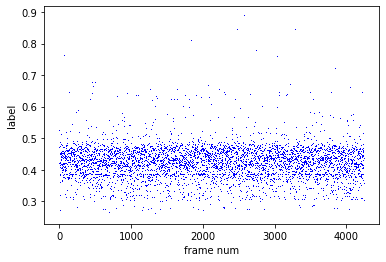

In [8]:
plt.plot(list_frame, list_label, 'b,')
plt.xlabel("frame num")
plt.ylabel("label")
plt.show()

I wanted to see which frames had a label of over .8 and if they were actually extremist or not

In [22]:
count = 0
list_over_eighty = []
for x in list_label:
    if (x > .8):
        list_over_eighty.append(list_frame[count])
    count += 1
print(list_over_eighty)

[1838, 2473, 2575, 3279]


In [19]:
import matplotlib.pyplot as plt

for frame in os.listdir(newDir):
    if count in list_over_eighty:
        print(frame)
    count += 1

Ofu46_3fnpF3HJJ3_frame_85.jpg
juBocUxytpstsEMD_frame_102.jpg
dN1eASbW14l9EQuF_frame_4.jpg
_FUNb16UE7wipW4H_frame_6.jpg


Unfortunately, the frames that were flagged as extremist were not extremist in nature. The extremist videos include only these 5 videos:

dGwq7CQ4FSQnF-Kc.mp4, E4RRHgsyXnams1UJ.mp4, FK7xpuzyVBVuVSIS.mp4, UJFieA4-1X0_0Rlr.mp4, and z-EoUCeasuaeVO1I.mp4

The model falsely flagged non-extremist videos and also failed to detect extremist videos